In [22]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import math
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_white
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

# Используемые функции 

##### Correlation

In [23]:
def correlation(x_data, y_data, return_result=False, print_result=False):
    result_dict = {'cof_correlation': None,
                  'p_value': None,
                  'is_significant_corr': False}
    
    result = pearsonr(x_data, y_data)
    
    result_dict['cof_correlation'] = result[0]
    result_dict['p_value'] = result[1]
    
    if print_result:
        print('coef correlation = ', result_dict['cof_correlation'] )
        print('p-value =', result_dict['p_value'])
    
    if result_dict['p_value'] > 0.05:
        if print_result:
            print('стaтистически НЕзначемый коэфицент')
    
    else:
        if print_result:
            print('стaтистически значемый коэфицент')
        result_dict['is_significant_corr'] = True
    
    if return_result:
        return result_dict

##### logarithm transformation

In [24]:
def log_transformation(col):
    return math.log(col)

##### check for normal distribution

In [25]:
def check_for_normal(data, return_result=False, print_result=False):
    result_dict = {
        'is_normal_distribution':False,
        'p_value': None
    }
    
    result = shapiro(data)
    result_dict['p_value'] = result.pvalue
    
    if result.pvalue > 0.05:
        result_dict['is_normal_distribution'] = True
        
    if  print_result:
        
        plt = sm.qqplot(data, line='45')
        plt.show()
        
        print('p-value = ', result.pvalue)
        if result.pvalue > 0.05:
            print('у нас не достаточно оснований отвергнуть H0. Данные распределены НОРМАЛЬНО')

        else:
            print('у нас не достаточно оснований принять H0. Данные  НЕ распределены НОРМАЛЬНО')
            
    if return_result:
        return result_dict

##### Проверка на гомоскедастичность

In [26]:
def homo_test(data, exog, return_result=False, print_result=False):
    result_dict = {'homo': False,
                  'p_value': None}
    
    white_test = het_white(data, exog)
    result_dict['p_value'] = white_test[1]
    
    if white_test[1] > 0.05:
        result_dict['homo'] = True
        
    if print_result:
        if white_test[1] > 0.05:
            print('У нас не достаточно оснований отклонить H0 гипотизу. Остатки гомоскеданстичны')
        
        else:
            print('У нас не достаточно принять H0 гипотизу. Остатки НЕ гомоскеданстичны')
    
    if return_result:
        return result_dict

# Начало проекта 

In [27]:
submission_data  = pd.read_csv('sample_submission.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [28]:
test_data = test_data.merge(submission_data, how='inner', on='vin')
test_data.shape

(110058, 15)

In [29]:
all_data = pd.concat([test_data, train_data])

In [30]:
all_data.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,sellingprice
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST),13592.209588
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST),13592.209588
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST),13592.209588
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST),13592.209588
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT),13592.209588


In [31]:
all_data.shape

(550294, 15)

# 1. Предобработка данных

In [32]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550294 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          550294 non-null  int64  
 1   make          540190 non-null  object 
 2   model         540092 non-null  object 
 3   trim          539843 non-null  object 
 4   body          537307 non-null  object 
 5   transmission  485822 non-null  object 
 6   vin           550294 non-null  object 
 7   state         550294 non-null  object 
 8   condition     538510 non-null  float64
 9   odometer      550206 non-null  float64
 10  color         549550 non-null  object 
 11  interior      549550 non-null  object 
 12  seller        550294 non-null  object 
 13  saledate      550294 non-null  object 
 14  sellingprice  550294 non-null  float64
dtypes: float64(3), int64(1), object(11)
memory usage: 67.2+ MB


## 1.1 Приведем все значения в колонках к нижнму регистру

In [33]:
string_columns = all_data.columns
string_columns = np.delete(string_columns, [0, 8, 13, 9, 14])

In [34]:
string_columns

Index(['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'color', 'interior', 'seller'],
      dtype='object')

In [35]:
for col in string_columns:
    all_data[col] = all_data[col].str.lower()

## 1.2 Найдем дубликаты

### 1.2.1 Явные дубликаты

In [36]:
all_data.duplicated(keep='last').sum()

0

### 1.2.2 Неявные дубликаты

In [37]:
for col in string_columns:
    print('===============', col, '=================')
    print(all_data[col].value_counts())
    print('================================')

=============== make =================
ford         92532
chevrolet    59619
nissan       53351
toyota       39439
dodge        30482
             ...  
ford tk          1
dodge tk         1
mazda tk         1
dot              1
airstream        1
Name: make, Length: 66, dtype: int64
=============== model =================
altima       19190
f-150        14145
fusion       12797
camry        12423
escape       11743
             ...  
42c              1
tlx              1
fleetwood        1
leganza          1
g500             1
Name: model, Length: 851, dtype: int64
=============== trim =================
base                54885
se                  43223
lx                  20609
limited             18052
lt                  16711
                    ...  
gt sulev                1
740ld xdrive            1
xdrive28d               1
ext base                1
4x4 v6 xlt sport        1
Name: trim, Length: 1901, dtype: int64
=============== body =================
sedan                   

## 1.3 Устранение выбросов

<b> устраним выбросы в odometer, sellingprice</b>

### 1.3.1 odometer

count    550206.000000
mean      68290.404683
std       53538.021892
min           1.000000
25%       28267.000000
50%       52061.000000
75%       99197.000000
max      999999.000000
Name: odometer, dtype: float64

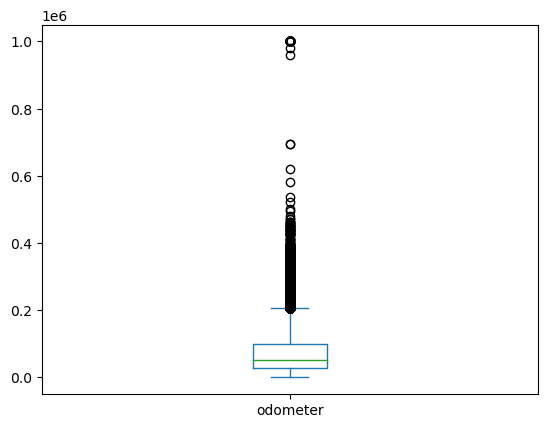

In [38]:

all_data['odometer'].plot(kind='box')
all_data['odometer'].describe()

In [39]:
all_data = all_data.loc[all_data['odometer'] < 350_000]
all_data = all_data.loc[all_data['odometer'] > 1000]

### 1.3.2 Sellingprice

In [40]:
all_data['sellingprice'] = all_data['sellingprice'] / 10

count    547416.000000
mean       1359.488531
std         866.690742
min          10.000000
25%         850.000000
50%        1359.220959
75%        1630.000000
max       23000.000000
Name: sellingprice, dtype: float64

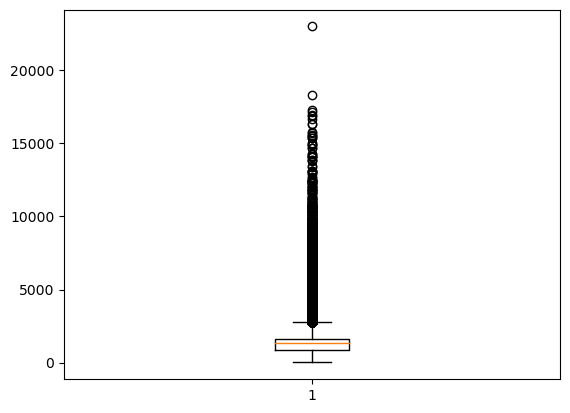

In [41]:
plt.boxplot(all_data['sellingprice'])
all_data['sellingprice'].describe()

In [42]:
all_data.loc[all_data['sellingprice'] > 12_500]['sellingprice'].count()

41

In [43]:
all_data = all_data.loc[all_data['sellingprice'] < 12_500]
all_data = all_data.loc[all_data['sellingprice'] > 20]

## 1.4 Заполнение пропусков

<b>есть пропущенные значения в transmission, make, model,trim,body, condition, color, interior, odometer</b>

удалим пропущенные значения из make

In [44]:
all_data = all_data.loc[all_data['make'].isna() == False]

заполним пропущенные значения в color, interior взяв самый часто встречающийся цвет и интерьер

In [45]:
all_data = all_data.loc[all_data['body'].isna() == False]

In [46]:
all_data = all_data.loc[all_data['model'].isna() == False]

заполним пропуски в transmission замым частым значением automatic

In [47]:
all_data['transmission'] = all_data['transmission'].fillna('automatic')

заполним пропуски в interior и color замым частым значением black и white

In [48]:
import random
def add_interior_color(col):
    if pd.isna(col) or col == '—':
        return random.choice(['black', 'gray'])
    else:
        return col

In [49]:
import random
def add_cars_color(col):
    if pd.isna(col) or col == '—':
        return random.choice(['black', 'white'])
    else:
        return col

In [50]:
all_data['interior'] = all_data['interior'].apply(add_interior_color)
all_data['color'] = all_data['color'].apply(add_interior_color)

### 1.4.1 Регрессионый анализ condition и odometer

<b>Для заполнения пропусков в condition и odometer проведем регрессионый анализ, и на основе построенной регрессии восполним пропущенные значения

In [51]:
condition_odometer = all_data[['condition', 'odometer', 'sellingprice']]
condition_odometer = condition_odometer.loc[(condition_odometer['condition'].isnull() == False) &
                                           (condition_odometer['odometer'].isnull() == False)]

#### correlation between condition and sellingprice

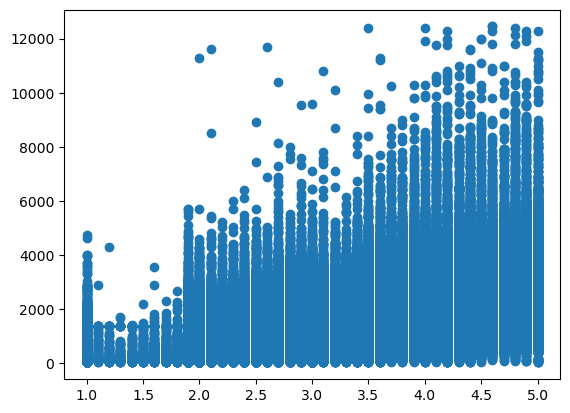

In [52]:
plt.scatter(condition_odometer['condition'], condition_odometer['sellingprice'])
plt.show()

In [53]:
correlation(condition_odometer['condition'], condition_odometer['sellingprice'])

мы имеем небольшой статистически незначемый коэфицент корреляции. Отсда делаем вывод, что в наших данных нету сильной зависимости между этими признаками. Но для заполнения пробелов все же построим регрессию, проведя логорифмическая трансформацию

### correlation between condition and odometer

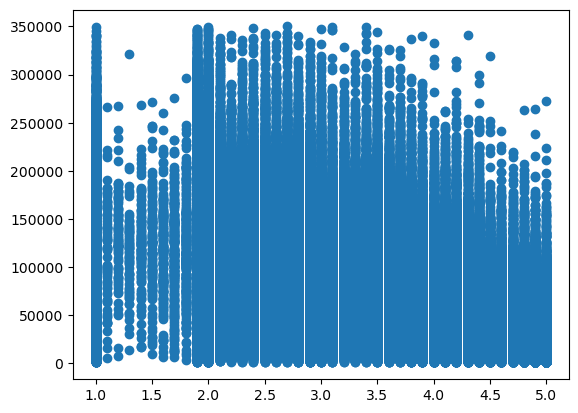

In [54]:
plt.scatter(condition_odometer['condition'], condition_odometer['odometer'])
plt.show()

In [55]:
correlation(condition_odometer['condition'], condition_odometer['odometer'])

имеем небольшой статистически значимый коэфицент корреляции. Но для заполнения пробелов все же построим регрессию, проведя логорифмическая трансформацию

<b>Логорифмическая трансформация</b>

In [56]:
condition_odometer['condition'] = condition_odometer['condition'].apply(log_transformation)
condition_odometer['sellingprice'] = condition_odometer['sellingprice'].apply(log_transformation)

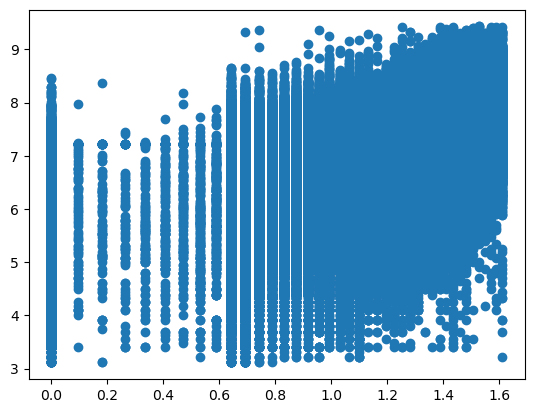

In [57]:
plt.scatter(condition_odometer['condition'], condition_odometer['sellingprice'])
plt.show()

In [58]:
correlation(condition_odometer['condition'], condition_odometer['sellingprice'])

In [59]:
for col in condition_odometer.columns:
    print('======= correalation', col, 'with condition ======')
    correlation(condition_odometer['condition'], condition_odometer[col], print_result=True)
    print('====================================================')

======= correalation condition with condition ======
coef correlation =  1.0
p-value = 0.0
стaтистически значемый коэфицент
======= correalation odometer with condition ======
coef correlation =  -0.5350336522933603
p-value = 0.0
стaтистически значемый коэфицент
======= correalation sellingprice with condition ======
coef correlation =  0.5575780652072561
p-value = 0.0
стaтистически значемый коэфицент


проверим на мультиколлиниарность предикторы odometer и sellingprice

In [60]:
correlation(condition_odometer['odometer'], condition_odometer['sellingprice'])

корреляция по модулю < 0.8 => мультиколлиниарность отсутсвует

### Построение регрессии

In [61]:
model = LinearRegression()

In [62]:
Y = condition_odometer['condition']
X = condition_odometer[['odometer', 'sellingprice']]

model = LinearRegression().fit(X, Y)
print('intercept: ', model.intercept_)
print('odometer: ',model.coef_[0])
print('sellingprice: ', model.coef_[1])


intercept:  0.3081184415185285
odometer:  -1.8417105631786329e-06
sellingprice:  0.14347791743309796


имеем уравнение видa: log(C) = 0.3081184415185285 -1.8417105631786329e-06 * log(O) + 0.14347791743309796 * log(S), где <br>
C - condition<br>
O - odometer<br>
S - sellingprice

теперь постром уровнение для odometer выразим эту переменную через имеющиеся уравнение регрессии 

In [63]:
intercept = 0.3081184415185285/1.8417105631786329e-06
condition = -(1 / 1.8417105631786329e-06)
sellingprice = 0.14347791743309796 / 1.8417105631786329e-06

In [64]:
print('intercept =',intercept)
print('condition = ', condition)
print('sellingprice = ', sellingprice)

intercept = 167300.1435072093
condition =  -542973.4834523003
sellingprice =  77904.70462713072


уравнение имеет вид log(O) = 167300.1435072093 - 542973.4834523003* log(C) + 77904.70462713072 * log(S), где <br>
C - condition<br>
O - odometer<br>
S - sellingprice

### 1.4.2 Заполнение пропусков в odometer и condition 

In [65]:
def add_odometer(row):
    if pd.isnull(row['odometer']) and (pd.isnull(row['condition']) == False):
        C = row['condition']
        S = row['sellingprice']
        O = 167300.1435072093 - 542973.4834523003* matm.log(C) + 77904.70462713072 * math.log(S)
        return mapth.exp(O)
    
    else:
        return row['odometer']
        

In [66]:
def add_condition(row):
    if pd.isnull(row['condition']) and (pd.isnull(row['odometer']) == False):
        O = row['odometer']
        S = row['sellingprice']
        C = 0.3081184415185285 - 1.8417105631786329e-06 * math.log(O) + 0.14347791743309796 * math.log(S)
        return round(math.exp(C), 1)
        
    else:
        return row['condition']

In [67]:
all_data['condition'] = all_data.apply(add_condition, axis=1)

In [68]:
all_data['condition'].isnull().sum()

0

In [69]:
all_data['odometer'].isnull().sum()

0

## 1.5 Добавление новых значений 

Добавим новый столбец "car_age" - возраст автомобиля = год выпуска - год продажи и переименнуем столбец 'saledate' в 'saleyear' оставив информацию только о годе проаджи, так как время и месяц никак не влияют на цену

In [70]:
years = [str(year) for year in range(1970, 2025)]

def add_sale_year(col):
    for year in years:
        if year in col:
            return int(year)

In [71]:
all_data['saledate'] = all_data['saledate'].apply(add_sale_year)

In [72]:
all_data = all_data.rename(columns={'saledate': 'saleyear'})

столбец "car_age"

In [73]:
all_data['car_age'] = all_data['saleyear'] - all_data['year']

# 2. Исследовательский анализ

## 2.1 Гипотезы

<b>Гипотеза 1</b><br>
Между пробегом (odometer) и ценой (sellingprice) имеется линейная взаимосвязь<br>
<b>Гипотеза 2</b><br>
Между состояние (condition) и ценой (sellingprice) имеется линейная взаимосвязь, но нужно делать поправку на модель авто <br>
<b> Гипотеза 3</b><br>
состояние (condition), пробег (odometer) и возраст автомобиля (car_age) влияют на ценой (sellingprice) и их зависимоть можно описать линейным уравнением вида <b>sellingprice = b0 + b1 * odometer + b2 * car_age + b3 * condition.</b> Но стоит делать поправку на модель автомобиля</b>

## 2.2 Проверка гипотез

### Проверка гипотезы 1.
между пробегом (odometer) и ценой (sellingprice) имеется взаимосвязь

<b>для проверки гипотезы проведем регрессионный анализ<b>

In [74]:
hypotis_1 = all_data[['sellingprice', 'odometer']]

<Axes: xlabel='sellingprice', ylabel='odometer'>

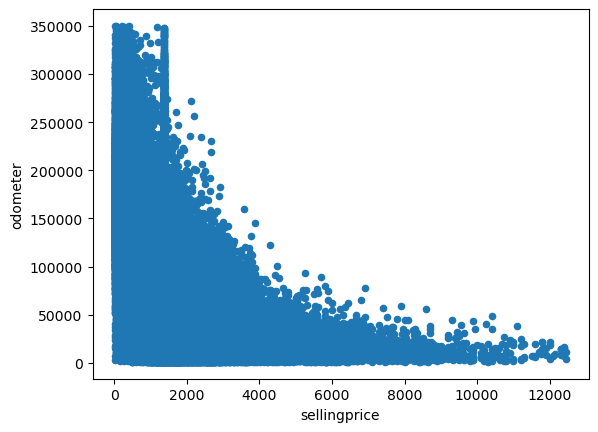

In [75]:
hypotis_1.plot(x='sellingprice', y = 'odometer', kind='scatter')

In [76]:
correlation(hypotis_1['odometer'], hypotis_1['sellingprice'])

<b>Проведем логорифмическую трансформацию одного из признаков для улучшениея коэфицента корреляции<b>

In [77]:
warnings.filterwarnings('ignore')
hypotis_1['sellingprice'] = hypotis_1['sellingprice'].apply(log_transformation)

In [78]:
correlation(hypotis_1['odometer'], hypotis_1['sellingprice'])

<Axes: xlabel='odometer', ylabel='sellingprice'>

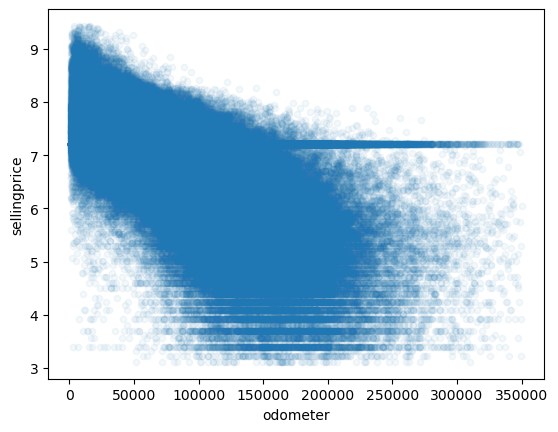

In [79]:
hypotis_1.plot(x='odometer', y = 'sellingprice', kind='scatter', alpha=0.05)

<b> Построение линейной регрессии

In [80]:
Y = hypotis_1['odometer']
X = hypotis_1['sellingprice']
X = sm.add_constant(X)

linear_model = sm.OLS(Y, X).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               odometer   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 4.154e+05
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:58:27   Log-Likelihood:            -6.3992e+06
No. Observations:              534264   AIC:                         1.280e+07
Df Residuals:                  534262   BIC:                         1.280e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.601e+05    457.307    787.347      0.000    3.59e+05    3.61e+05
sellingprice -4.193e+04     65.056   -644.528      0.000   -4.21e+04   -4.18e+04
==============================================================================
Omnibus:                   125103.533   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           347766.856
Skew:                           1.245   Prob(JB):                         0.00
Kurtosis:                       6.070   Cond. No.                         62.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-квадрат равен 0.437 , что указывает на то, что 0.437% дисперсии odometer можно объяснить изменением sellingprice. Уравнение имеет вид <b>odometer = 3.601e+05 - 4.193e+04 * log(sellingprice)</b>

<b>Проверка на гомоскедастичность

посмотрим на распределение остатков

In [81]:
remains = linear_model.resid

count    5.342640e+05
mean     1.123556e-08
std      3.851203e+04
min     -2.145198e+05
25%     -2.592659e+04
50%     -7.321849e+03
75%      1.863041e+04
max      2.905238e+05
dtype: float64

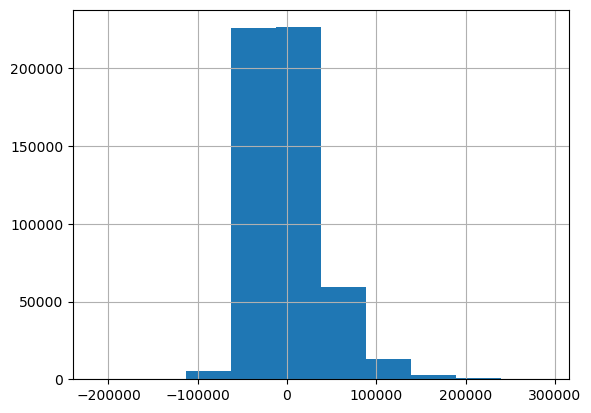

In [82]:
remains.hist()
remains.describe()

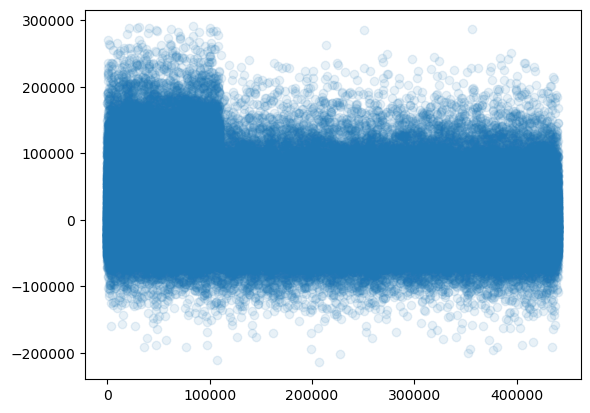

In [83]:
plt.scatter(x=remains.index, y=remains.values, alpha=0.1)

Проверка остатков на нормальное распределение

p-value =  0.0
у нас не достаточно оснований принять H0. Данные  НЕ распределены НОРМАЛЬНО


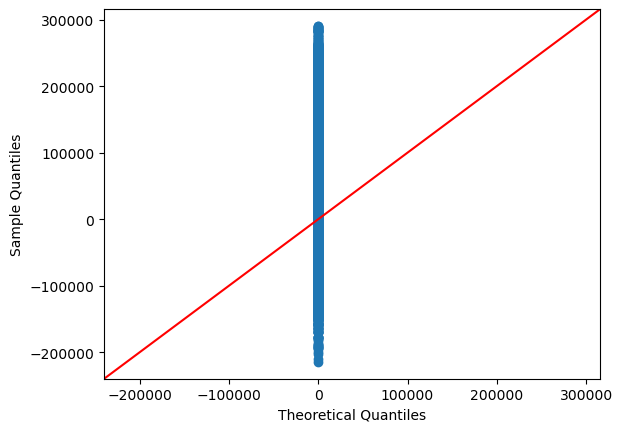

In [86]:
warnings.filterwarnings('ignore')
check_for_normal(remains, print_result=True)

### Вывод. Гипотеза 1

из-за отсутсвтия нормального распредления у остатков гомоскеданстичность отсутствует, зависимость вида odometer = 3.601e+05 - 4.193e+04 * log(sellingprice)
не подтверждена. <b>ОПРОВЕРГНУТО между пробегом (odometer) и ценой (sellingprice) НЕТУ линенйой зависимости</b>

### Допущение по Гипотезе 1

Пусть у нас и отсутвует гомоскеданстичность из-за чего мы не можем принять гипотезу о наличии линейной зависимости между (odometer) и ценой (sellingprice), но мы можем проверить эту гипотезу для каждой марки автомобиля. Ведь очиыидно, что например ферари с проббегом 10 000 км будет все равно стоить дороже, чем kia c пробьегом в 5 000 км. Но ферари с пробегом 15 000 км, моэет стоить дешевле, чем ферари с пробегом в 5 000 км

### Проверка допущения по гипотезе 1

Разобъем автомобили на модели и для каждой моедели проверим гипотизу о наличии линейной зависимости между пробегом (odometer) и ценой (sellingprice)

<b> Используемые функции </b>

In [87]:
def add_another_type(col):
    if col not in car_models:
        return 'another'
    else:
        return col

<b> функция подбора логарифической трансофрмации</b>

In [88]:
def choise_log_transf(data, independent_var):
    best_res = correlation(data[independent_var], data['sellingprice'], return_result=True)

    odo_log_data = data[independent_var].apply(log_transformation)
    price_log_data = data['sellingprice'].apply(log_transformation)

    odo_result = correlation(odo_log_data, data['sellingprice'], return_result=True)
    price_result = correlation(data[independent_var], price_log_data, return_result=True)
    odo_price_result = correlation(odo_log_data, price_log_data, return_result=True)


    if abs(odo_price_result['cof_correlation']) > abs(best_res['cof_correlation']) and odo_price_result['is_significant_corr']:
        data['sellingprice'] = price_log_data
        data[independent_var] = odo_log_data
        best_res = odo_price_result
        models_stat['log_transf'].append(True)

    else:
        models_stat['log_transf'].append(False)
        
    models_stat['corr'].append(best_res['cof_correlation'])
    models_stat['is_significant_corr'].append(best_res['is_significant_corr'])
    
    return data

<b>функция регрессионного анализа</b>

In [89]:
def regression_analysis(data, independent_var):
    Y = data['sellingprice']
    X = data[independent_var]
    X = sm.add_constant(X)

    linear_model = sm.OLS(Y, X).fit()
    
    remains = linear_model.resid
    white_test = homo_test(remains, linear_model.model.exog, return_result=True)
    models_stat['homo'].append(white_test['homo'])
    models_stat['white_pvalue'].append(white_test['p_value'])

### Начало анализа

для постороения уравнения ргересии возьмем оптимальное минимальное количество наблюдений ранвное 100. Отберем телько те модели, где количесвто наблюдений > 100. Моделям, которых меньше 100 дадим категорию "another"

In [90]:
warnings.filterwarnings('ignore')
count_models = all_data['model'].value_counts()
car_models = count_models.loc[count_models > 100].index
assumption_hyp_1 = all_data[['model', 'odometer', 'sellingprice']]
assumption_hyp_1['model'] = assumption_hyp_1['model'].apply(add_another_type)

In [91]:
models_stat = {'model': [],
              'corr': [],
              'is_significant_corr': [],
              'log_transf': [],
              'white_pvalue': [],
              'homo': [],
              'count_model':[]}

In [92]:
models = assumption_hyp_1['model'].unique()

<b>Проведение регрессионого анализа для всех типов моделей</b>

In [93]:
warnings.filterwarnings('ignore')
for model in models:
    count_model = assumption_hyp_1.loc[assumption_hyp_1['model'] == model]['model'].count()
    models_stat['count_model'].append(count_model)
    models_stat['model'].append(model)
    
    model_data = assumption_hyp_1.loc[assumption_hyp_1['model'] == model]
    model_data = choise_log_transf(model_data, 'odometer')
    regression_analysis(model_data, 'odometer')

In [94]:
reg_analysis_results = pd.DataFrame(models_stat)

<b>резульаты</b>

In [95]:
reg_analysis_results

,model,corr,is_significant_corr,log_transf,white_pvalue,homo,count_model
0,cts,-0.737963,True,False,8.956595e-34,False,1883
1,savana cargo,-0.699683,True,True,1.153355e-43,False,655
2,murano,-0.771594,True,False,9.711974e-143,False,2847
3,impala,-0.671919,True,True,0.000000e+00,False,7793
4,titan,-0.750590,True,False,1.298501e-17,False,773
...,...,...,...,...,...,...,...
393,venture,-0.207806,True,True,1.742369e-01,True,176
394,g5,-0.363522,True,True,3.054280e-03,False,134
395,bonneville,-0.285572,True,True,5.257229e-01,True,129
396,montero sport,-0.298204,True,True,3.954130e-01,True,149


#### Анализ результатов

In [96]:
reg_analysis_results['homo'].value_counts()

False    351
True      47
Name: homo, dtype: int64

в большинстве случаев (87%) гомоскедастичность отсутствует.

In [97]:
reg_analysis_results.loc[reg_analysis_results['homo'] == True].head(10)

,model,corr,is_significant_corr,log_transf,white_pvalue,homo,count_model
12,fiesta,-0.390778,True,False,0.092489,True,2333
24,alero,-0.260520,True,True,0.654742,True,123
61,fr-s,-0.473369,True,False,0.542069,True,161
93,elantra gt,-0.401571,True,False,0.382426,True,236
102,sonic,-0.346592,True,False,0.354226,True,1756
106,dart,-0.456572,True,False,0.575441,True,998
130,tiburon,-0.477581,True,True,0.257788,True,187
146,century,-0.249619,True,True,0.065851,True,200
147,rogue select,-0.207054,True,False,0.125494,True,128
155,stratus,-0.243044,True,True,0.560551,True,287


In [98]:
reg_analysis_results.loc[reg_analysis_results['homo'] == True]['count_model'].median()

181.0

Данных о моделях, где пресутствует гомоседастичность и небольшой коэфицент корреляции всреднем 181, что и говорит об малом коэфиценте корреляции. Так же у нас недостаточно оснований принять наличие хоть како-нибудь гомоскедостичности, так как выборка, где она присутсвует слишком мала

### Общий вывод по допущению о гипотезе 1

<b> Гипотеза 1 - ОПРОВЕРГНУТО</b><br>
<b> Допущение по гипотезе 1  - ОПРОВЕРГНУТО</b>.

Допущение о том, что все-таки линейная зависимость между ценой и на автомобиль и пробегом имеется, но нужно делать попраку на модель авто, не имеется возможным принять, так как недостаточно оснований.
1. в 87% присутвовала гетероскадастичность
2. в случаях, когда гомоскадастичность присутвовала, данных было мало, примерно 181

### Гипотеза 2.

Между цена автомобиля линейно зависима от состояние автомобиля, но нужно делать поправку на модель авто, ведь ферари в состояниеи 5/10 может стоить дороже, чем kia состоянием 8/10

для постороения уравнения ргересии возьмем оптимальное минимальное количество наблюдений ранвное 100. Отберем телько те модели, где количесвто наблюдений > 100. Моделям, которых меньше 100 дадим категорию "another"

In [99]:
warnings.filterwarnings('ignore')
count_models = all_data['model'].value_counts()
car_models = count_models.loc[count_models > 100].index
hyp_2 = all_data[['model', 'condition', 'sellingprice']]
hyp_2['model'] = assumption_hyp_1['model'].apply(add_another_type)

In [100]:
models_stat = {'model': [],
              'corr': [],
              'is_significant_corr': [],
              'log_transf': [],
              'white_pvalue': [],
              'homo': [],
              'count_model':[]}

In [101]:
models = assumption_hyp_1['model'].unique()

<b>Проведение анализа для всех типов моеделей<b>

In [102]:
warnings.filterwarnings('ignore')
for model in models:
    count_model = hyp_2.loc[assumption_hyp_1['model'] == model]['model'].count()
    models_stat['count_model'].append(count_model)
    models_stat['model'].append(model)
    
    model_data = hyp_2.loc[assumption_hyp_1['model'] == model]
    model_data = choise_log_transf(model_data, 'condition')
    regression_analysis(model_data, 'condition')

In [103]:
reg_analysis_results = pd.DataFrame(models_stat)

<b>Резултаты<b>

In [104]:
reg_analysis_results

,model,corr,is_significant_corr,log_transf,white_pvalue,homo,count_model
0,cts,0.553564,True,False,5.087457e-03,False,1883
1,savana cargo,0.513028,True,True,2.836539e-47,False,655
2,murano,0.603824,True,False,1.404193e-01,True,2847
3,impala,0.480620,True,True,4.712341e-246,False,7793
4,titan,0.648545,True,False,2.151878e-03,False,773
...,...,...,...,...,...,...,...
393,venture,0.266710,True,True,3.812012e-01,True,176
394,g5,0.048578,False,False,6.276196e-02,True,134
395,bonneville,0.436292,True,True,9.730533e-02,True,129
396,montero sport,0.258031,True,True,1.646326e-02,False,149


<b> Анализ результатов <b>

In [105]:
reg_analysis_results['homo'].value_counts()

False    330
True      68
Name: homo, dtype: int64

в большинстве случаев (85%) гомоскедастичность отсутствует.

In [106]:
reg_analysis_results.loc[reg_analysis_results['homo'] == True]['count_model'].median()

197.0

Данных о моделях, где пресутствует гомоседастичность и небольшой коэфицент корреляции, всреднем 197, что и говорит об малом коэфиценте корреляции. Так же у нас недостаточно оснований принять наличие хоть како-нибудь гомоскедостичности, так как выборка, где она присутсвует слишком мала

### Вывод по гипотезе 2

<b> Гипотеза 2 - ОПРОВЕРГНУТО</b><br>
Допущение о том, что все-таки линейная зависимость между ценой и на автомобиль и его состоянием имеется, но нужно делать попраку на модель авто, не имеется возможным принять, так как недостаточно оснований.
1. в 87% присутвовала гетероскадастичность
2. в случаях, когда гомоскадастичность присутвовала, данных было мало, примерно 181

### Проверка гипотеза 3. 

состояние (condition), пробег (odometer) и возраст автомобиля (car_age) влияют на ценой (sellingprice) и их зависимоть можно описать линейным уравнением вида <b>sellingprice = b0 + b1 * odometer + b2 * car_age + b3 * condition.</b> Но стоит делать поправку на модель автомобиля</b>

для постороения уравнения ргересии возьмем оптимальное минимальное количество наблюдений ранвное 100. Отберем телько те модели, где количесвто наблюдений > 100. Моделям, которых меньше 100 дадим категорию "another"

##### Используемые функции

In [107]:
def found_remains(model, X, Y):
    return model.predict(X) - Y

##### матрица корреляций

In [108]:
def correlation_matrix(colums_1, columns_2):
    corr_matrix = {'name_1': [],
                   'name_2': [],
                  'correlation': [],
                  'is_significant_corr': []}

    for col_1 in colums_1:
        for col_2 in columns_2:
            result = correlation(model_data[col_1], model_data[col_2], return_result=True)
            corr_matrix['name_1'].append(col_1)
            corr_matrix['name_2'].append(col_2)
            corr_matrix['correlation'].append(result['cof_correlation'])
            corr_matrix['is_significant_corr'].append(result['is_significant_corr'])
            
    return corr_matrix

##### нахождение мультиколлиниарности

In [109]:
def found_multicollinarity(data):
    multicollinarity_vars = {'name_1': [],
                           'name_2': []}
    
    mult = False
    
    for i in range(len(data['name_1'])):
        if (data['name_1'][i] != data['name_2'][i]) and data['correlation'][i] > 0.75 and data['is_significant_corr']:
            multicollinarity_vars['name_1'].append(data['name_1'][i])
            multicollinarity_vars['name_2'].append(data['name_2'][i])
            mult = True
            
        
    result_analysis['mult'].append(mult)        
    return multicollinarity_vars

##### удаление мультиколлиниарности

In [110]:
def del_multicollinarity(data, X):
    if len(data['name_1']) != 0:
        multicollinarity_col = data['name_1'][1]
        X = X.drop(columns=multicollinarity_col, axis=1)

##### нахождение корреляции 

In [111]:
def corr_Y_X(X, Y, X_col):
    for col in X_col:
        res = correlation(X[col], Y, return_result=True)
        result_analysis[col].append(res['cof_correlation'])
        result_analysis[col + '_stat'].append(res['is_significant_corr'])

##### построение регресии

In [112]:
def regration_analysis_2(X, Y):
    regration_model = LinearRegression().fit(X, Y)
    remains = found_remains(regration_model, X, Y)
    result = check_for_normal(remains, return_result=True)
    if result['is_normal_distribution']:
        result_analysis['remains_norm_dist'].append(True)
    else:
        result_analysis['remains_norm_dist'].append(False)

In [113]:
warnings.filterwarnings('ignore')
count_models = all_data['model'].value_counts()
car_models = count_models.loc[count_models > 100].index
hyp_3 = all_data[['sellingprice', 'odometer', 'car_age', 'condition', 'model']]
hyp_3['model'] = assumption_hyp_1['model'].apply(add_another_type)

In [114]:
result_analysis = {
    'model': [],
    'odometer':[],
    'odometer_stat':[],
    'car_age': [],
    'car_age_stat':[],
    'condition':[],
    'condition_stat':[],
    'mult': [],
    'remains_norm_dist': [],
    'count_model':[]
}

In [115]:
models = assumption_hyp_1['model'].unique()

<b> Проведение анализа для каждой модели авто <b>

In [116]:
warnings.filterwarnings('ignore')
for model in models:    
    model_data = hyp_3.loc[assumption_hyp_1['model'] == model]
    result_analysis['model'].append(model)
    count_model = hyp_3.loc[hyp_3['model'] == model]['model'].count()
    result_analysis['count_model'].append(count_model)
    
    X = model_data[['odometer', 'car_age', 'condition']]
    Y = model_data['sellingprice']

    corr_matrix = correlation_matrix(['odometer', 'car_age', 'condition'], ['odometer', 'car_age', 'condition'])
    corr_Y_X(X, Y, ['odometer', 'car_age', 'condition'])
    found_mult_result = found_multicollinarity(corr_matrix)
    
    del_multicollinarity(found_mult_result, X)

    regration_analysis_2(X, Y)

In [117]:
result_analysis_frame = pd.DataFrame(result_analysis)

<b> Результаты <b>

In [118]:
result_analysis_frame

,model,odometer,odometer_stat,car_age,car_age_stat,condition,condition_stat,mult,remains_norm_dist,count_model
0,cts,-0.737963,True,-0.795884,True,0.553564,True,False,False,1883
1,savana cargo,-0.653659,True,-0.653469,True,0.428454,True,True,False,655
2,murano,-0.771594,True,-0.790215,True,0.603824,True,True,False,2847
3,impala,-0.669445,True,-0.632590,True,0.446752,True,True,False,7793
4,titan,-0.750590,True,-0.772647,True,0.648545,True,False,False,773
...,...,...,...,...,...,...,...,...,...,...
393,venture,-0.050593,False,-0.003237,False,0.096330,False,False,False,176
394,g5,-0.207510,True,-0.174127,True,0.048578,False,False,False,134
395,bonneville,-0.104490,False,-0.039908,False,0.280050,True,False,False,129
396,montero sport,-0.137885,False,-0.019094,False,0.128165,False,False,False,149


<b> Анализ результатов<b>

In [119]:
result_analysis_frame['remains_norm_dist'].value_counts()

False    392
True       6
Name: remains_norm_dist, dtype: int64

только в 1% случаев остатки были распредлены нормально.

Медианное значения корреляциий

In [120]:
for var in ['odometer', 'car_age', 'condition']:
    print('Медианное значение корреляции,', var, ' и "sellingprice": ', result_analysis_frame[var].median())

Медианное значение корреляции, odometer  и "sellingprice":  -0.577771458207575
Медианное значение корреляции, car_age  и "sellingprice":  -0.5515212534709244
Медианное значение корреляции, condition  и "sellingprice":  0.4123325441284204


корреляции odometer и car_age с sellingprice примерно одинаковые. Корреляции очень низкие, что говорит о слабой зависимости 

In [121]:
for var in ['odometer_stat', 'car_age_stat', 'condition_stat']:
    print('===========', var, '============')
    print(result_analysis_frame[var].value_counts())

=========== odometer_stat ============
True     374
False     24
Name: odometer_stat, dtype: int64
=========== car_age_stat ============
True     343
False     55
Name: car_age_stat, dtype: int64
=========== condition_stat ============
True     360
False     38
Name: condition_stat, dtype: int64


в большинстве случаев, коэйифенты корреляция c sellingprice статистически значимы

In [122]:
result_analysis_frame['mult'].value_counts()

False    263
True     135
Name: mult, dtype: int64

в 33% случаев была мультиколлиниарность. Скорее всего, это между car_age и odometer

<b>Проверим наличие мульиколлиниарнсоти между odometer и condition во общих данных</b>

In [123]:
for col_1 in ['condition', 'odometer', 'car_age']:
    for col_2 in ['car_age', 'condition']:
        print('======= correalation', col_1, 'with', col_2,' ======')
        correlation(all_data[col_1], all_data[col_2], print_result=True)
        print('====================================================')

======= correalation condition with car_age  ======
coef correlation =  -0.5390712980962913
p-value = 0.0
стaтистически значемый коэфицент
======= correalation condition with condition  ======
coef correlation =  0.999999999999999
p-value = 0.0
стaтистически значемый коэфицент
======= correalation odometer with car_age  ======
coef correlation =  0.7987505792691068
p-value = 0.0
стaтистически значемый коэфицент
======= correalation odometer with condition  ======
coef correlation =  -0.5436590462420671
p-value = 0.0
стaтистически значемый коэфицент
======= correalation car_age with car_age  ======
coef correlation =  1.0
p-value = 0.0
стaтистически значемый коэфицент
======= correalation car_age with condition  ======
coef correlation =  -0.5390712980962913
p-value = 0.0
стaтистически значемый коэфицент


car_age и odometer имеют статистически значммы и выской коэфицент корреляции - 80%, что говрит о <b>наличие мультиколлиниарнсоти в общих данных</b>

### Вывод по гипотезе 3
состояние (condition), пробег (odometer) и возраст автомобиля (car_age) влияют на ценой (sellingprice) и их зависимоть можно описать линейным уравнением вида <b>sellingprice = b0 + b1 * odometer + b2 * car_age + b3 * condition.</b> Но стоит делать поправку на модель автомобиля</b>

1. Отсутсвие нормального распредления остатков, говорит о том, что коэфиценты регресси b0..b3 являются смещенныим,что моежет говорить либо об отсутсвие линейной зависимости, либо о сильных выбросах. 
2. Mедианное значение коэфицентов корреляции для odometer, car_age, condition слишком низкое: -57, -55. -41 соответсвенно, что также говрит о слабой линейной зависимости с sellingprice.
3. Так же, отсутвия в python пакетов со статистическими тестами для проверки множественной ргересии на гетероскадстичность и невозможност провести данные тесте не дает основания для принятие гипотизы и линейно зависимости вида sellingprice = b0 + b1 * odometer + b2 * car_age + b3 * condition
4. в 33% в случаев была мультиколлиниарность
5. только в 1% случаев остатки были распредлены нормально.<br>
<b> У нас не достаточно оснований для принятия гипотезы 3</b>

# Общий вывод по исследовательскому анализу 

1. Линейной зависимости между пробегом(odometer) и ценой (sellingprice) нету, точно так же, как и между состоянием (condition) и ценой, даже несмотря на допущение о том, что нужно учитывать модель автомобиля. Возможно имеется другая, не линейная свзяь
2. У нас не имеется достаточных онсований для описания зависимости цены вида sellingprice = b0 + b1 * odometer + b2 * car_age + b3 * condition
3. В данных общих данных была найдена мультиколлиниарнсоть между car_age и odometer.
4. Были рассмотренны переменные которые больше моугт влять на цену и значений которых достаточно для проведения анлиза, а именно odometer, age_year, condition, model.
5. На основе экспертного подхода был сдела вывод, что такие переменные, как trim, body, seller, inetrior, state, color, make никак не влияют или вляют оченб слабо на цену

<b> У нас недостаточно оснований для утверждения, что между зависимой переменной sellingprice и объясняющими переменными имеется линенйая зависиомсть, которую можно описать регрессионным уравнением.</b> Вследствии чего, для для дальнейшей модели описания данных в предиктивной аналитике будут использоваться нелинейные модели

# 2. Предиктивная аналитика

##### Используемые функции

##### кодирование данных

In [101]:
def ordinal_encoding(X_train, X_test, X_categorical):    
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    encoder.fit(X_train[X_categorical])
    X_train[X_categorical] = encoder.transform(X_train[X_categorical])
    X_test[X_categorical] = encoder.transform(X_test[X_categorical])
    
    return X_train, X_test, encoder

In [102]:
def ohe_encoding(X_train, X_test, X_categorical):
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
    encoder.fit(X_train[X_categorical])
                            
    X_train_tranform = pd.DataFrame(data = encoder.transform(X_train[X_categorical]),
                                       columns = encoder.get_feature_names_out(),
                                       index = X_train.index)

    X_test_tranform = pd.DataFrame(data = encoder.transform(X_test[X_categorical]),
                                       columns = encoder.get_feature_names_out(),
                                       index = X_test.index)
                            
                
    X_train_ohe = X_train.drop(X_categorical, axis=1)
    X_train_ohe = X_train_ohe.join(X_train_tranform)
    
    X_test_ohe = X_test.drop(X_categorical, axis=1)
    X_test_ohe = X_test_ohe.join(X_test_tranform)
                            
    return X_train_ohe, X_test_ohe, encoder

##### стандартизация данных

In [103]:
def data_standartization(X_train, X_test, columns_to_transform):
    pd.options.mode.chained_assignment = None
    
    scalar = StandardScaler()
    scalar.fit(X_train[columns_to_transform])
    
    X_train[columns_to_transform] = scalar.transform(X_train[columns_to_transform])
    X_test[columns_to_transform] = scalar.transform(X_test[columns_to_transform])
    
    return X_train, X_test, scalar

## 2.1 Подготовка данных

In [104]:
X_var = all_data.drop(['sellingprice', 'car_age', 'vin', 'saleyear', 'seller'], axis=1)
Y_var = all_data['sellingprice']

### 2.1.1 Разбиение на независимые переменные X и зависимую переменную Y

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(X_var, Y_var, 
                                                    test_size = 0.2059992812542114, 
                                                    random_state = 42)

In [106]:
X_train

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior
140754,2014,dodge,grand caravan,sxt,minivan,automatic,tn,1.0,37894.0,silver,black
67153,2012,mercedes-benz,c-class,c300 luxury 4matic,sedan,automatic,ga,2.9,19480.0,black,black
178214,2007,saturn,aura,xr,sedan,automatic,md,3.5,89172.0,gray,gray
121348,2011,nissan,maxima,3.5 s,sedan,automatic,ca,2.3,87432.0,gray,black
21661,2008,dodge,nitro,slt,suv,automatic,nc,2.0,82762.0,black,gray
...,...,...,...,...,...,...,...,...,...,...,...
3485,2014,dodge,charger,se,sedan,automatic,ga,2.0,25145.0,white,black
156827,2014,nissan,altima,2.5 s,sedan,automatic,nc,4.3,25622.0,silver,black
266648,2013,ford,escape,se,suv,automatic,tn,4.2,16117.0,green,gray
25795,2006,dodge,ram pickup 1500,laramie,quad cab,automatic,nj,2.9,85819.0,white,gray


### 2.1.2 Стандартизация данных

In [107]:
columns_to_transform = ['odometer', 'condition', 'year']

In [108]:
X_train, X_test, scalar = data_standartization(X_train, X_test, columns_to_transform)

In [109]:
X_train

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior
140754,0.992439,dodge,grand caravan,sxt,minivan,automatic,tn,-2.608126,-0.572744,silver,black
67153,0.475970,mercedes-benz,c-class,c300 luxury 4matic,sedan,automatic,ga,-0.575475,-0.931473,black,black
178214,-0.815201,saturn,aura,xr,sedan,automatic,md,0.066415,0.426218,gray,gray
121348,0.217736,nissan,maxima,3.5 s,sedan,automatic,ca,-1.217365,0.392321,gray,black
21661,-0.556967,dodge,nitro,slt,suv,automatic,nc,-1.538309,0.301343,black,gray
...,...,...,...,...,...,...,...,...,...,...,...
3485,0.992439,dodge,charger,se,sedan,automatic,ga,-1.538309,-0.821112,white,black
156827,0.992439,nissan,altima,2.5 s,sedan,automatic,nc,0.922268,-0.811819,silver,black
266648,0.734205,ford,escape,se,suv,automatic,tn,0.815286,-0.996989,green,gray
25795,-1.073435,dodge,ram pickup 1500,laramie,quad cab,automatic,nj,-0.575475,0.360898,white,gray


### 2.1.2 Добавление фиктивынх переменных 

In [110]:
columns_to_endcoder = ['make', 'model', 'trim', 'body', 'transmission',
                       'state', 'color', 'interior']

#### 2.1.2.1 Ordinal encoder

In [111]:
X_train_ord, X_test_ord, ordinal_encoder = ordinal_encoding(X_train, X_test, columns_to_endcoder)

## 2.2 Подбор гиперпараметров и обучение

In [112]:
max_depth = list(range (2,20))
n_estimators = list(range(7,50,2))
min_samples_split = list(range(6,15,2))
min_samples_leaf =  list(range(4,15))
ccp_alpha = np.arange(0, 1, 0.05)
criterion = ['gini', 'entropy', 'log_loss']

In [113]:
estimators_values_list = np.arange(10, 50, 5)
reg_alpha_values_list = np.arange(0, 1, 0.05)
depth_values_list = np.arange(10, 50, 5)

In [114]:
test_grid = {'rf__n_estimators': estimators_values_list,
              'rf__max_depth': depth_values_list,  
              'rf__ccp_alpha': reg_alpha_values_list}

### 2.2.1 Ансамбль градиентного бустинга

In [115]:
lgbm_params_dict = { 
        "lgbm__max_depth": max_depth,
        "lgbm__n_estimators": n_estimators,
        "lgbm__min_samples_split": min_samples_split,
        "lgbm__min_samples_leaf": min_samples_leaf,
        "lgbm__ccp_alpha": ccp_alpha,
        "lgbm__criterion": criterion
    }

In [128]:
def lgbm_select_hyper_params(X_train, Y_train, params_dict):
    
    
    pipeline = Pipeline([ ('lgbm', lgb.LGBMModel(objective='regression', verbose = -1)) ])
    
    grid_search = RandomizedSearchCV(estimator=pipeline,
                                param_distributions=params_dict,
                                n_iter=200,    
                                scoring = 'neg_mean_squared_error',
                                cv=5,
                                n_jobs=-1,
                                random_state=423
                                )
    grid_search.fit(X_train, Y_train)
    
    print("Best Hyperparameters: ", grid_search.best_params_)
    print("Best train score: ", grid_search.best_score_)
    
    return grid_search.best_params_,  grid_search.best_score_

In [129]:
lgbm_hyper_params, lgbm_train_best_score = lgbm_select_hyper_params(X_train_ord, Y_train, lgbm_params_dict)

Best Hyperparameters: {'lgbm__n_estimators': 49, 'lgbm__min_samples_split': 6, 'lgbm__min_samples_leaf': 13, 'lgbm__max_depth': 11, 'lgbm__criterion': 'gini', 'lgbm__ccp_alpha': 0.75}
Best train score -236298.49575487612


### 2.2.2 Случайный лес

In [130]:
rf_params_dict = {
        "rf__max_depth": max_depth,
        "rf__n_estimators": n_estimators,
        "rf__min_samples_split": min_samples_split,
        "rf__min_samples_leaf": min_samples_leaf,
        "rf__ccp_alpha": ccp_alpha
    }

In [133]:
def rf_select_hyper_params(X_train, Y_train, params_dict):
    
    pipeline = Pipeline([
    ('rf', RandomForestRegressor(random_state=42))
        ])
    
    grid_search = RandomizedSearchCV(estimator=pipeline,
                                param_distributions=params_dict,
                                n_iter=200,
                                scoring = 'neg_mean_squared_error',
                                cv=5,
                                n_jobs=-1,
                                random_state=42)
    grid_search.fit(X_train, Y_train)
    
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best train score", grid_search.best_score_)
    
    return grid_search.best_score_, grid_search.best_score_

In [134]:
rf_hyper_params, rf_train_best_score = rf_select_hyper_params(X_train_ord, Y_train, rf_params_dict)

Best Hyperparameters: {'rf__n_estimators': 43, 'rf__min_samples_split': 6, 'rf__min_samples_leaf': 6, 'rf__max_depth': 18, 'rf__ccp_alpha': 0.55}
Best train score -189015.31927157362


## 2.3 Выбор наилучшей модели

Так как ансамбль градиентного бустинга показал лучше оценку прри обучении, чем случайный лес - neg_mean_squared_error = -189015 для случайного леса и neg_mean_squared_error = -236298 для градиентного бустинга, то будет выбрана модель ансамбля градиентго бустинга со следующими гиперпараметрами: <br>
n_estimators = 49<br>
min_samples_split= 6<br>
min_samples_leaf = 6<br>
max_depth = 18 <br>
ccp_alpha = 0.55 <br>

# 3.  Обучение и тестовый прогноз

In [140]:
final_model = lgb.LGBMModel(objective='regression',
                            verbose = -1,
                            max_depth=18, 
                            min_samples_split = 6,
                            n_estimators = 49,
                            min_samples_leaf = 6,
                            ccp_alpha = 0.55,
                            criterion = 'gini',
                            random_state=123, 
                            n_jobs = -1)

final_model.fit(X_train_ord, Y_train)
Y_predict = final_model.predict(X_test_ord)
MSE = mean_squared_error(Y_test, Y_predict)
MAPE = mean_absolute_percentage_error(Y_test, Y_predict)
R2 = r2_score(Y_test, Y_predict)

In [141]:
print('MSE: ', MSE)
print('MAPE:', MAPE)
print('R2: ', R2)

MSE:  237271.85701593274
MAPE: 0.5041777106033973
R2:  0.6712291574715015


In [142]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'importances coef': final_model.feature_importances_
})
feature_importances.sort_values('importances coef', ascending=False)

,Feature,importances coef
2,model,347
1,make,312
3,trim,273
4,body,231
0,year,109
8,odometer,86
7,condition,65
10,interior,25
9,color,15
6,state,7


Больше всего на цену влияет model, make, trim, boody

In [143]:
test_predict = pd.Series(Y_predict, name='predict')

## Вывод по предиктивной аналитике 

Были выявленны признаки, котороые влияют на цену больше всего:<br>
1. model <br>
2. make <br>
3. trim <br>
4. body <br>
Однако выский показатель MAPE = 0.5 и не столь выской R2 = 0.67 для построенной моедели не дает оснований для предположения о налисии четкой зависимости в данных

# Общий вывод по работе

<b>Сильной зависимости между данными не удлаось обноружить.<br><b>
1. Линейной взаимосвязи нету по причине того, что при регрессионном анализе объясняющих перменных, которые больше всего могут влиять на цену автомобиля (odometer, condition, car_age) не были выполнены условия успешного регрессионного анализа: Остатки модели не подчиняются гаусовскому распределению, наличие гетероскдастичности, наличие маленькой корреляции.<br>
2. Допущение о том, что линейная зависимость имеется между ценой и пробегом авто, но важным фактором является модель автомобиля также не подтверждена. Псоле проведения регрессионного анализа отдельно для каждой моедли улсовия успешного регрессионного анализа также не были выполнены. в 87% случаях присутвовала гетероскадастичность<br>
3. Преположение, что зависимость можно описать уравнением вида sellingprice = b0 + b1 * odometer + b2 * car_age + b3 * condition
после проведения регрессионного анализа для каждой модели автомобиля, так же не было принято, так как только в 1% случаев остатки были распредлены нормально. Так же отстутвие пакетов в python для проверки на гомосеедастичность множетсвенную регрессию не дает возможность подтвердить или опровергнуть наличие гетероскдастичности<br>
4. Наличие большой вариативности данных в номинативвных переменнах не предоставляет возможным провезти полноценный регрессионный анализ и попытатья выразить зависимость цены уравнением линейного вида. В каждой номинативной переменной может находится до 14 000 различных вариаций данных, например в переменной seller 14 000 различных выдов продацов.<br>
5. Наличие высокого значения MAPE = 0.5 и не столь выское значение R2 = 0.67 говорит о невозможности четко описать зависимоть в данных неленейной моделью описания gradient boosting random forest<br>
6. Обнаружены факторы, влияющие больше всего на цену - model, make, trim, boody но из-за не состоятельности модели описания у нас нету оснований принять достоверность их влияния<br>